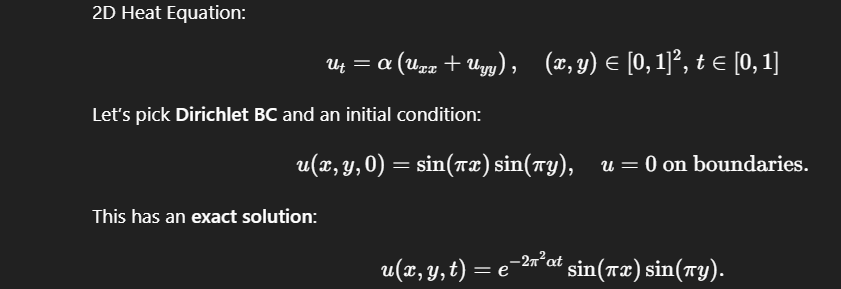

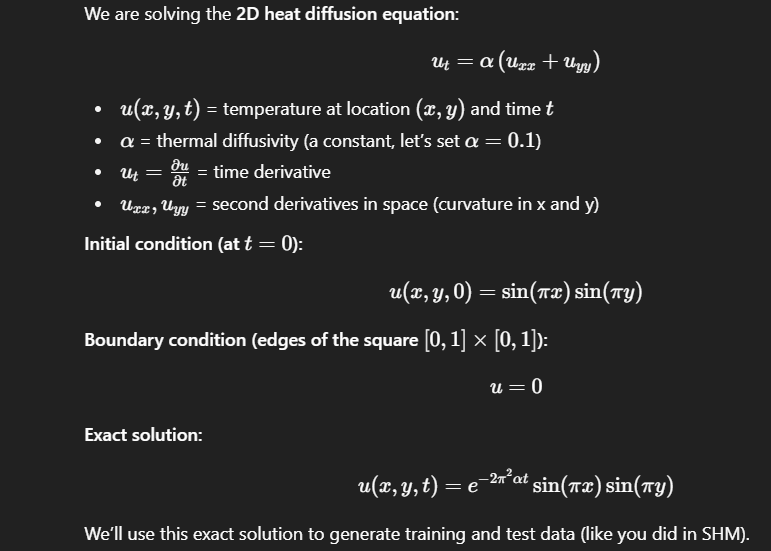

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Parameters
alpha = 0.1
N_points = 10000  # number of data points

In [ ]:
# Sample random (x,y,t) points
x = np.random.rand(N_points, 1)
y = np.random.rand(N_points, 1)
t = np.random.rand(N_points, 1)

print (x,y,t)

[[0.94051735]
 [0.91601945]
 [0.59491207]
 ...
 [0.1348243 ]
 [0.74797626]
 [0.67520044]] [[0.59768716]
 [0.34569303]
 [0.38398091]
 ...
 [0.33607317]
 [0.75829478]
 [0.90261738]] [[0.12454984]
 [0.440078  ]
 [0.90638874]
 ...
 [0.64651524]
 [0.42927019]
 [0.9822025 ]]


In [ ]:
# Exact solution for u(x,y,t)
u_exact = np.exp(-2 * (np.pi**2) * alpha * t) * np.sin(np.pi * x) * np.sin(np.pi * y)


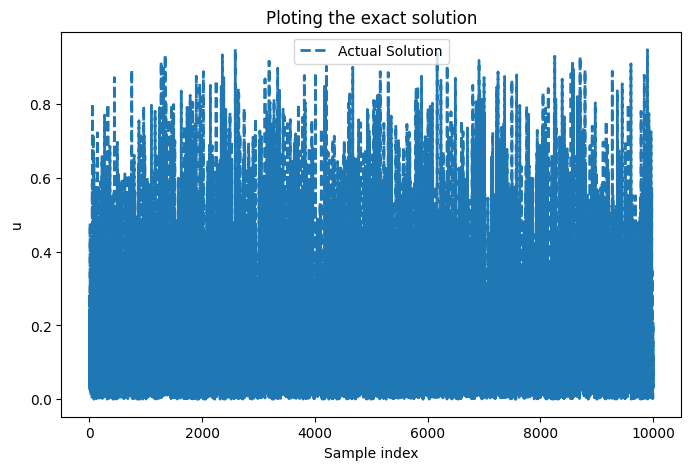

In [ ]:
import matplotlib.pyplot as plt

# --- Plot ---
plt.figure(figsize=(8,5))

plt.plot(u_exact, '--', label="Actual Solution", linewidth=2)
plt.xlabel("Sample index")
plt.ylabel("u")
plt.title("Ploting the exact solution")
plt.legend()
plt.show()


In [ ]:
# Combine into dataset
data = np.hstack((x, y, t, u_exact))

# Train-test split 80% train 20% test
train, test = train_test_split(data, test_size=0.2, random_state=42)

x_train, y_train, t_train, u_train = train[:,0:1], train[:,1:2], train[:,2:3], train[:,3:4]
x_test,  y_test,  t_test,  u_test  = test[:,0:1],  test[:,1:2],  test[:,2:3],  test[:,3:4]


## Defining the NN

In [ ]:
import torch
import torch.nn as nn

# Convert training data to tensors
x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_train, dtype=torch.float32, requires_grad=True)
t_train = torch.tensor(t_train, dtype=torch.float32, requires_grad=True)
u_train = torch.tensor(u_train, dtype=torch.float32)

# Define Neural Network
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, y, t):
        inp = torch.cat([x,y,t], dim=1)
        for i, layer in enumerate(self.layers[:-1]):
            inp = torch.tanh(layer(inp))  # activation
        return self.layers[-1](inp)  # output layer


In [ ]:

# --- device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# --- instantiate model ---
model = PINN([3, 50, 50, 50, 1]).to(device)

# --- Xavier initialization (good for tanh) ---
def init_weights(m):
    if isinstance(m, nn.Linear):
        gain = nn.init.calculate_gain('tanh')
        nn.init.xavier_normal_(m.weight, gain=gain)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_weights)

# --- sanity check ---
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print("Model parameters:", count_params(model))

# small forward pass
x = torch.rand(4,1, device=device, requires_grad=True)
y = torch.rand(4,1, device=device, requires_grad=True)
t = torch.rand(4,1, device=device, requires_grad=True)
u_pred = model(x, y, t)
print("u_pred shape:", u_pred.shape)  # expected (4,1)


Using device: cpu
Model parameters: 5351
u_pred shape: torch.Size([4, 1])


## Defning the Loss Function


DATA LOSS
$$
L_{\text{data}} = \| u_\theta(x,y,t) - u_{\text{exact}} \|^2
$$


In [ ]:
def data_loss(model, x, y, t, u):
    u_pred = model(x,y,t)
    return torch.mean((u_pred - u)**2)


PHYSICS LOSS$$
LPDE = \| u_t - \alpha (u_{xx} + u_{yy}) \|^2
$$


In [ ]:
def physics_loss(model, x, y, t, alpha=0.1):
    u = model(x,y,t)

    # First derivatives
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]

    # Second derivatives
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]

    # PDE residual
    f = u_t - alpha*(u_xx + u_yy)
    return torch.mean(f**2)


  #### TOTAL LOSS = DATA LOSS + PHYSICS LOSS
$$
L_{\text{total}} = \lambda_{\text{data}} L_{\text{data}} + \lambda_{\text{PDE}} L_{\text{PDE}}
$$


In [ ]:
def total_loss(model, x, y, t, u):
    l_data = data_loss(model, x, y, t, u)
    l_pde = physics_loss(model, x, y, t)
    return l_data + l_pde, l_data, l_pde


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2000):
    optimizer.zero_grad()
    loss, l_data, l_pde = total_loss(model, x_train, y_train, t_train, u_train)
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Total={loss.item():.6f}, Data={l_data.item():.6f}, PDE={l_pde.item():.6f}")


Epoch 0: Total=3.084164, Data=2.826310, PDE=0.257854
Epoch 200: Total=0.017126, Data=0.014863, PDE=0.002263
Epoch 400: Total=0.010893, Data=0.008877, PDE=0.002015
Epoch 600: Total=0.008192, Data=0.006741, PDE=0.001451
Epoch 800: Total=0.006385, Data=0.005404, PDE=0.000980
Epoch 1000: Total=0.005121, Data=0.004382, PDE=0.000739
Epoch 1200: Total=0.004314, Data=0.003679, PDE=0.000635
Epoch 1400: Total=0.003762, Data=0.003221, PDE=0.000541
Epoch 1600: Total=0.003338, Data=0.002881, PDE=0.000457
Epoch 1800: Total=0.002978, Data=0.002575, PDE=0.000403


In [ ]:
x_test_t = torch.tensor(x_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)
t_test_t = torch.tensor(t_test, dtype=torch.float32)
u_test_t = torch.tensor(u_test, dtype=torch.float32)

u_pred = model(x_test_t, y_test_t, t_test_t).detach().numpy()
error = np.mean((u_pred - u_test)**2)
print("Test MSE:", error)


Test MSE: 0.0023528438750584817


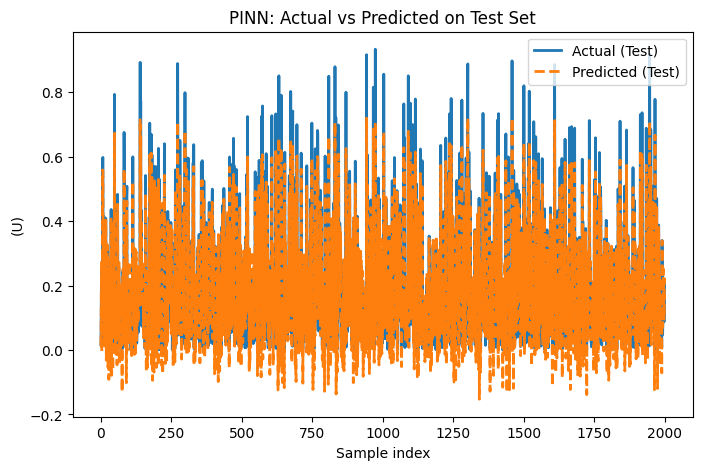

In [ ]:
# Convert to torch tensors
x_test_t = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)
t_test_t = torch.tensor(t_test, dtype=torch.float32).to(device)


# True values (already numpy from the split)
u_true_test = u_test

u_pred_test = u_pred

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(u_true_test, label="Actual (Test)", linewidth=2)
plt.plot(u_pred_test, '--', label="Predicted (Test)", linewidth=2)
plt.xlabel("Sample index")
plt.ylabel("(U)")
plt.title("PINN: Actual vs Predicted on Test Set")
plt.legend()
plt.show()
